<a href="https://colab.research.google.com/github/s1102498/DeepLearning/blob/main/multi_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import tensorflow as tf
from sklearn.model_selection import train_test_split

path_img = "/content/gdrive/My Drive/polmonedx-sx/CXR_png"
path_mask_sx = "/content/gdrive/My Drive/polmonedx-sx/ManualMask/leftMask"
path_mask_dx = "/content/gdrive/My Drive/polmonedx-sx/ManualMask/rightMask"

img_width = 192
img_heigth = 272
seed = 42

#i vettori contengono la lista con i nomi delle immagini : ['MXCM0001.png', 'MXCM0002.png' ..]
name_imgs_train, name_imgs_test = train_test_split(os.listdir(path_img), test_size = 0.30, random_state = seed)
name_imgs_train, name_imgs_val = train_test_split(name_imgs_train, test_size = 0.20, random_state = seed)

##UNET MODEL

E' stata scelta una funzione di attivazione 'ELU' (unità lineare esponenziale) poichè hanno valori negativi che consentono di spingere le attivazioni delle unità medie più vicine allo zero.  Le 'ELU' portano non solo a un apprendimento più rapido ma anche a migliori prestazioni di generalizzazione una volta che le reti hanno molti livelli (≥ 5).

E' stato utilizzato un metodo di inizializzazione del peso chiamato 'He' invece che Glorot con lo scopo che questi inizializzatori di peso riescono a trovare una buona varianza per la distribuzione da cui sono tratti i parametri iniziali. Questa variazione è adattata alla nostra funzione di attivazione. Nella carta Glorot , infatti, si usa una distribuzione uniforme mentre nella carta He si sceglie una gaussiana.

Usiamo un livello di esclusione 'Dropout' tra due livelli di convoluzione questo aiuta a prevenire l'overfitting e il co-adattamento delle caratteristiche. 
Lo 0,1% dei nodi verrà eliminato durante il passaggio in avanti e all'indietro.


In [3]:
import numpy as np 
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
from tensorflow.keras import backend as k



def unet(input_size = (192,272,1), n_class = 1):

  inputs = Input(input_size)

  #DownSampling
  c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
  c1 = Dropout(0.1) (c1)
  c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
  p1 = MaxPooling2D((2, 2)) (c1)

  c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
  c2 = Dropout(0.1) (c2)
  c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
  p2 = MaxPooling2D((2, 2)) (c2)

  c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
  c3 = Dropout(0.2) (c3)
  c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
  p3 = MaxPooling2D((2, 2)) (c3)

  c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
  c4 = Dropout(0.2) (c4)
  c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
  p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
 
  #BottleNeck
  c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
  c5 = Dropout(0.3) (c5)
  c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

  #UpSampling
  u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
  c6 = Dropout(0.2) (c6)
  c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

  u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
  c7 = Dropout(0.2) (c7)
  c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
  c8 = Dropout(0.1) (c8)
  c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
  c9 = Dropout(0.1) (c9)
  c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

  outputs = Conv2D(n_class, (1, 1), activation='softmax') (c9) #3 neuroni finali, uno per ogni canale 

  model = Model(inputs=[inputs], outputs=[outputs])

  return model

In [4]:

def preprocessing(imgs, path_img, path_mask_dx, path_mask_sx, x, y, n_class):

  X = np.empty((len(imgs), x, y, 1))           #tensore 4D per le immagini reali : 1 = scala di grigi
  Y = np.empty((len(imgs), x, y, n_class))     #tensore 4D per le maschere : 3 = classi da segmentare

  dim = (y, x)
  i = 0

  for img in imgs:
    image = cv2.imread(os.path.join(path_img, img),0)
    image = cv2.resize(image, dim)
    mea = np.mean(image)
    ss = np.std(image)
    image = (image - mea)/ss

    mask_dx = cv2.imread(os.path.join(path_mask_dx,img), 0)
    mask_sx = cv2.imread(os.path.join(path_mask_sx,img), 0)
    mask_n = cv2.add(mask_dx,mask_sx)
    mask_n = (255 - mask_n) / 255
    mask_n = cv2.resize(mask_n, dim)
    
    mask_dx = mask_dx / 255
    mask_dx = cv2.resize(mask_dx, dim)
    mask_sx = mask_sx / 255
    mask_sx = cv2.resize(mask_sx, dim)

    #mask_sx = mask_sx*2
    #mask = cv2.add(mask_dx,mask_sx)
    #mask = cv2.resize(mask, dim)

    X[i,:,:,0] = image

    Y[i,:,:,0] = mask_n
    Y[i,:,:,1] = mask_dx
    Y[i,:,:,2] = mask_sx
    i+=1
  
  return X,Y


In [5]:
X_train, Y_train = preprocessing(name_imgs_train, path_img, path_mask_dx, path_mask_sx, img_width, img_heigth, 3)
X_val, Y_val = preprocessing(name_imgs_val, path_img, path_mask_dx, path_mask_sx, img_width, img_heigth, 3 )

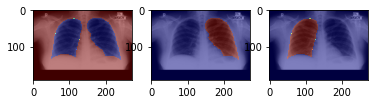

In [ ]:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(X_train[10,:,:,0],cmap='gray')
ax[0].imshow(Y_train[10,:,:,0],'jet', interpolation='none', alpha=0.5)

ax[1].imshow(X_train[10,:,:,0],cmap='gray')
ax[1].imshow(Y_train[10,:,:,1],'jet', interpolation='none', alpha=0.5)

ax[2].imshow(X_train[10,:,:,0],cmap='gray')
ax[2].imshow(Y_train[10,:,:,2],'jet', interpolation='none', alpha=0.5)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range = 25,
    #width_shift_range = 10,
    #height_shift_range = 10,
    #zoom_range = 0.05,
    fill_mode='constant')

train_mask_datagen = ImageDataGenerator(
    rotation_range = 25,
    #width_shift_range = 10,
    #height_shift_range = 10,
    #zoom_range = 0.05,
    fill_mode='constant')

vali_datagen = ImageDataGenerator()
vali_mask_datagen = ImageDataGenerator()

train_datagen.fit(X_train, augment=True, seed=seed)
train_mask_datagen.fit(Y_train, augment=True, seed=seed)
train_image_generator = train_datagen.flow(X_train,batch_size = 8, shuffle = True, seed=seed)
train_mask_generator = train_mask_datagen.flow(Y_train,batch_size = 8, shuffle = True, seed=seed)
train_generator = zip(train_image_generator,train_mask_generator)

vali_datagen.fit(X_val, seed=seed)
vali_mask_datagen.fit(Y_val, seed=seed)
val_image_generator = vali_datagen.flow(X_val,batch_size = 8, seed=seed)
val_mask_generator = vali_mask_datagen.flow(Y_val,batch_size = 8, seed=seed)
val_generator = zip(val_image_generator,val_mask_generator)

In [7]:
model = unet(n_class = 3)

In [8]:
model.compile(optimizer = Adam(lr = 0.0001), loss = "categorical_crossentropy", metrics = ['accuracy'])
steps_per_epoch = np.ceil(len(name_imgs_train) / 8)
history = model.fit(train_generator, steps_per_epoch = steps_per_epoch, epochs = 10,
                    validation_data = val_generator, verbose = 1, validation_steps=len(name_imgs_val)/8)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
10/10 [==============================] - 51s 374ms/step - loss: 1.0219 - accuracy: 0.4269 - val_loss: 0.7863 - val_accuracy: 0.6742
Epoch 2/10
10/10 [==============================] - 1s 120ms/step - loss: 0.7398 - accuracy: 0.6512 - val_loss: 0.6710 - val_accuracy: 0.7468
Epoch 3/10
10/10 [==============================] - 1s 116ms/step - loss: 0.6705 - accuracy: 0.7049 - val_loss: 0.6300 - val_accuracy: 0.7551
Epoch 4/10
10/10 [==============================] - 1s 117ms/step - loss: 0.5992 - accuracy: 0.7437 - val_loss: 0.6083 - val_accuracy: 0.7557
Epoch 5/10
10/10 [==============================] - 1s 117ms/step - loss: 0.5403 - accuracy: 0.7757 - val_loss: 0.5298 - val_accuracy: 0.7786
Epoch 6/10
10/10 [==============================] - 1s 117ms/step - loss: 0.4776 - accuracy: 0.8024 - val_loss: 0.4774 - val_accuracy: 0.7951
Epoch 7/10
10/10 [==============================] - 1s 115ms/step - loss: 0.6924 - accuracy: 0.7899 - val_loss: 0.6348 - val_accuracy: 0.7869
Epoch

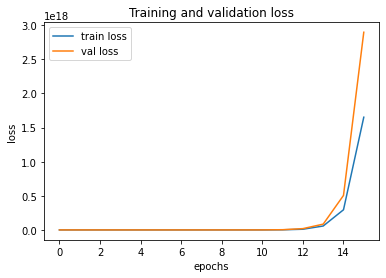

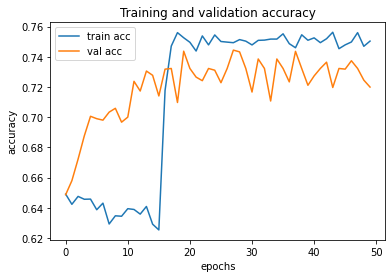

In [ ]:
epochs = 50

plt.figure()
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(np.arange(0, epochs), history.history["loss"], label="train loss")
plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val loss")
plt.legend()

plt.figure()
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(np.arange(0, epochs), history.history["categorical_accuracy"], label="train acc")
plt.plot(np.arange(0, epochs), history.history["val_categorical_accuracy"], label="val acc")
plt.legend()


In [9]:
X_test, Y_test = preprocessing(name_imgs_test, path_img, path_mask_dx, path_mask_sx, img_width, img_heigth, 3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


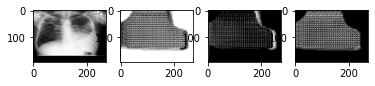

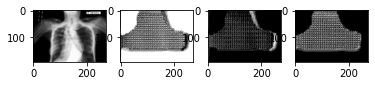

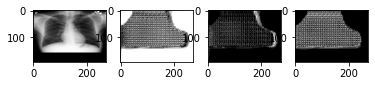

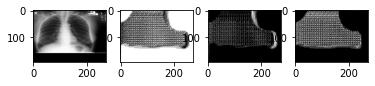

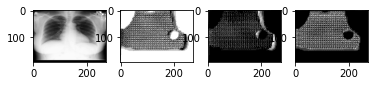

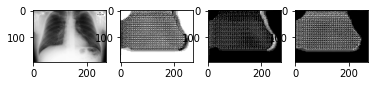

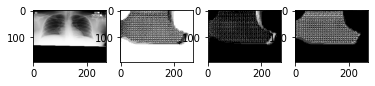

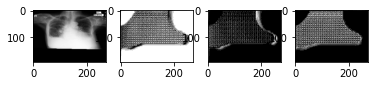

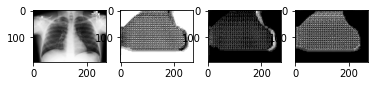

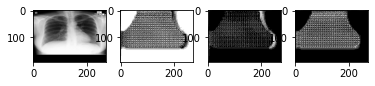

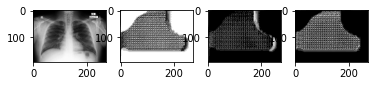

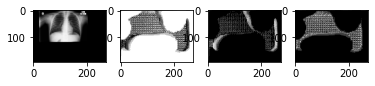

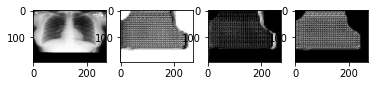

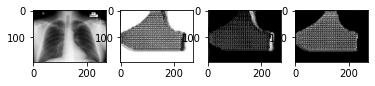

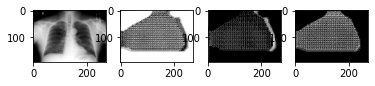

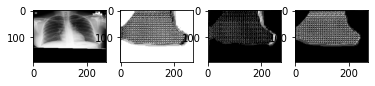

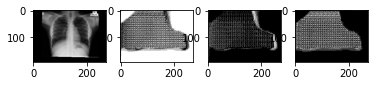

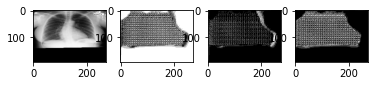

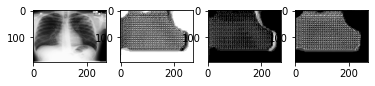

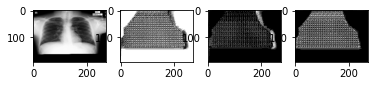

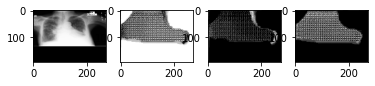

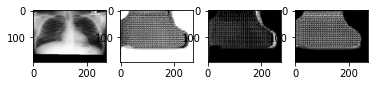

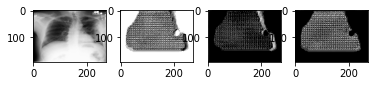

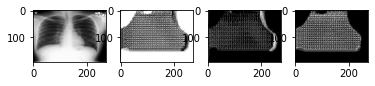

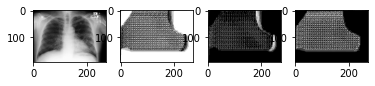

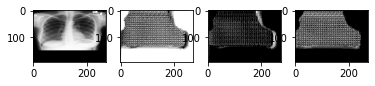

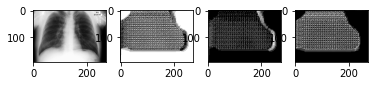

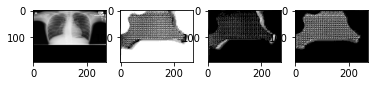

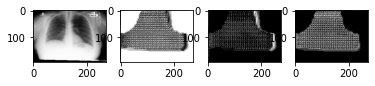

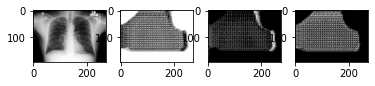

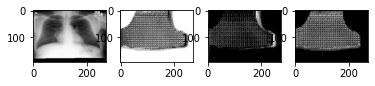

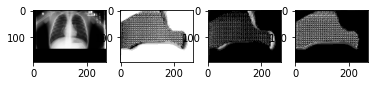

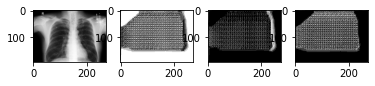

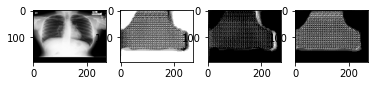

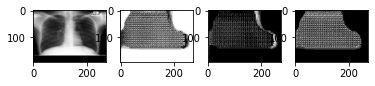

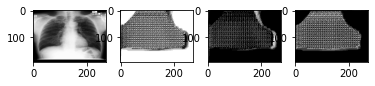

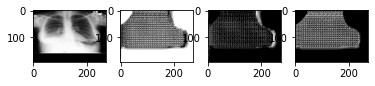

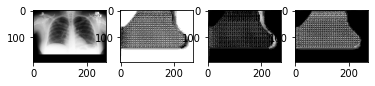

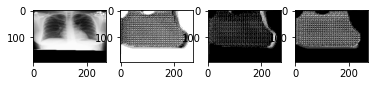

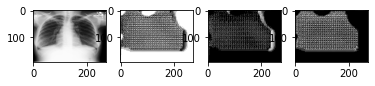

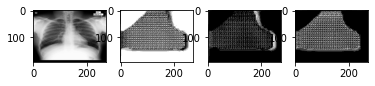

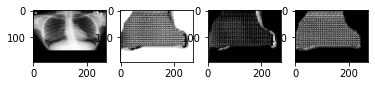

In [10]:
from sklearn.metrics import accuracy_score


prediction = model.predict(X_test)

for tensor_3d_idx in range(prediction.shape[0]):
  tensor_3d = prediction[tensor_3d_idx]

  fig, ax = plt.subplots(1, 4)  
  ax[0].imshow(X_test[tensor_3d_idx,:,:,0], cmap='gray')

  #plt.figure(tensor_3d_idx)
  #plt.imshow(X_train[tensor_3d_idx,:,:,0],cmap='gray')

  for channel_idx in range(tensor_3d.shape[2]):
    channel_pred = tensor_3d[:,:, channel_idx]
    channel_pred[channel_pred > 0.6]  = 1
    channel_pred[channel_pred <= 0.6] = 0

    ax[channel_idx+1].imshow(channel_pred, cmap='gray')

    #plt.imshow(channel_pred,'jet', interpolation='none', alpha=0.5)


In [11]:
from sklearn.metrics import accuracy_score

for i in range(Y_test.shape[0]):
  for j in range(Y_test.shape[3]):
    a = Y_test[i,:,:,j].flatten()
    b = prediction[i,:,:,j].flatten()
    a = a.astype(int)
    b = b.astype(int)

    accuracy = accuracy_score(a, b)
    print("testing accuracy {}         ".format(j), accuracy)
  print()

testing accuracy 0          0.6800704656862745
testing accuracy 1          0.7989047181372549
testing accuracy 2          0.7390663296568627

testing accuracy 0          0.6531479779411765
testing accuracy 1          0.8018344056372549
testing accuracy 2          0.7686695772058824

testing accuracy 0          0.6785577512254902
testing accuracy 1          0.8062576593137255
testing accuracy 2          0.7529488357843137

testing accuracy 0          0.7057291666666666
testing accuracy 1          0.8135531556372549
testing accuracy 2          0.7659313725490197

testing accuracy 0          0.6783662683823529
testing accuracy 1          0.8232038909313726
testing accuracy 2          0.7607230392156863

testing accuracy 0          0.6544500612745098
testing accuracy 1          0.7785500919117647
testing accuracy 2          0.7105736825980392

testing accuracy 0          0.7330154718137255
testing accuracy 1          0.8643918504901961
testing accuracy 2          0.7950367647058824

testin